In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d.art3d import pathpatch_2d_to_3d
import numpy as np
import open3d as o3d
import seaborn as sns
from scipy import spatial
from tqdm.auto import tqdm

from pspd.points import remove_hidden_points
from pspd.misc import edblquad

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%matplotlib widget

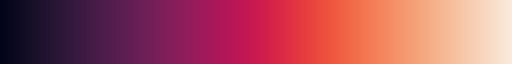

In [3]:
# constants
elev = 25
azim = 50
cmap = sns.color_palette('rocket', as_cmap=True)
cmap

In [4]:
# data
fname = os.path.join('data', 'model', 'head.scaled')
points = np.loadtxt(fname + '.xyz') 
normals = np.loadtxt(fname + '.normals')
mesh = o3d.io.read_triangle_mesh(fname + '.iso.watertight.off')
vert = np.asarray(mesh.vertices)
tri = np.asarray(mesh.triangles)

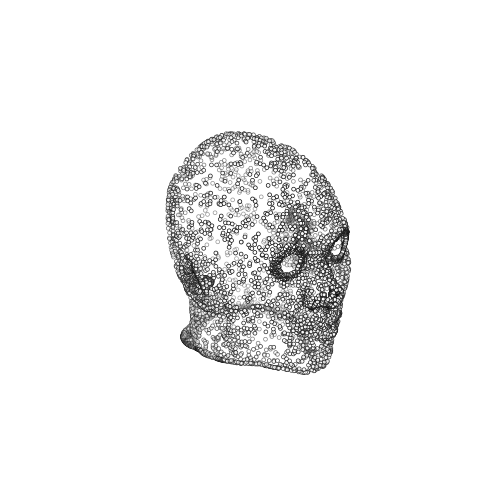

In [5]:
# point cloud
N = points.shape[0]
num = 0.1 * N
mask = np.arange(0, N, int(N/num))

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points[mask].T,
           fc='w', ec='k', s=7.5, lw=0.5)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

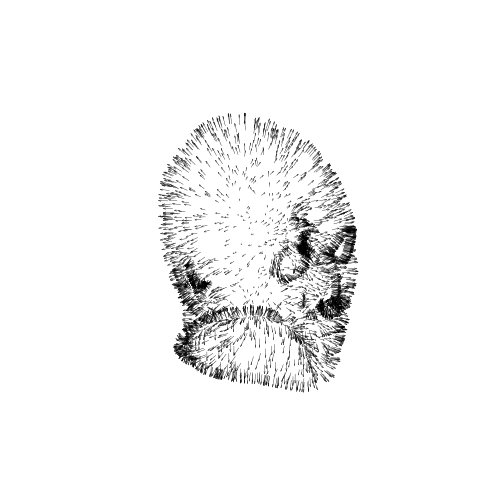

In [6]:
# normals
N = points.shape[0]
num = 0.05 * N
mask = np.arange(0, N, int(N/num))

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.quiver(*points[mask].T, *normals[mask].T,
          color='k', normalize=True, lw=0.25)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

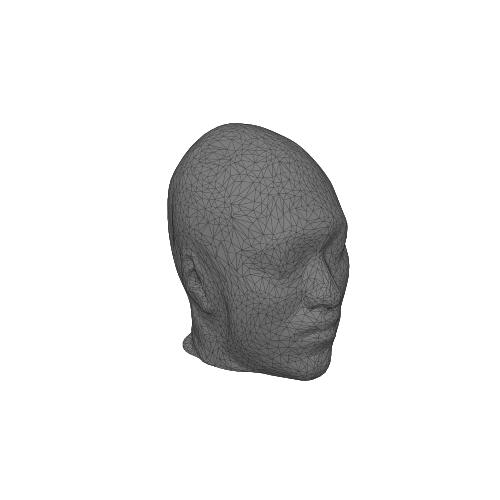

In [7]:
# surface
mesh_smp = mesh.simplify_quadric_decimation(6500)
vert_smp = np.asarray(mesh_smp.vertices)
tri_smp = np.asarray(mesh_smp.triangles)
ls = LightSource(elev+20, azim)

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.plot_trisurf(*vert_smp.T, triangles=tri_smp,
                color='gray', ec='k', lw=0.05, lightsource=ls)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

# Algorithm for the automatic detection of the psPD

In [108]:
def gen_power_density(query_point, points, r, I0):
    dist = np.linalg.norm((points - query_point) / np.array([1, 0.5, 0.25]),
                          axis=1)
    return I0 * np.exp(-(dist / r) ** 2)

In [110]:
query_point = points[points[:, 0].argmax(), :]
power_density = gen_power_density(query_point, points, 2.5, 10)

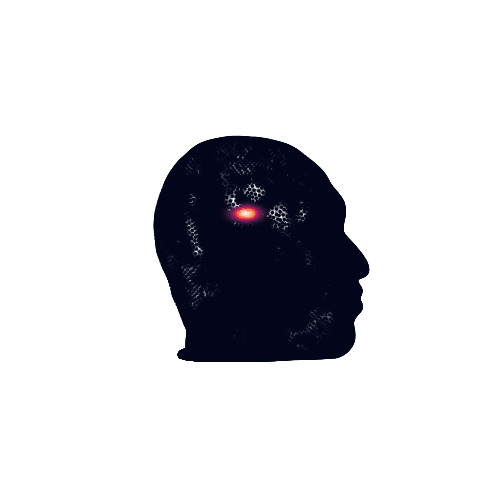

In [111]:
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points.T, c=power_density, cmap=cmap, s=2.5)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.set_axis_off()
ax.view_init(0, 0)
plt.show()

In [9]:
pov = np.mean(points, axis=0)
diameter = np.linalg.norm(points.ptp(axis=0))
pov[0] += 2 * diameter
pov[1] += 0.5 * diameter

In [52]:
projected_area = 4
a = np.sqrt(projected_area)

In [11]:
from pspd import PSPD

pspd = PSPD(points, power_density, mesh=mesh)
pspd.find(projected_area, pov=pov, p=np.pi)

  0%|          | 0/24995 [00:00<?, ?it/s]

In [12]:
res = pspd.get_results()
p = res['query point']
nbh = res['k-neigborhood']
nbh_mesh = res['evaluation surface']
area = res['surface area']
pd = res['power density']
spd = res['spatially averaged power density']

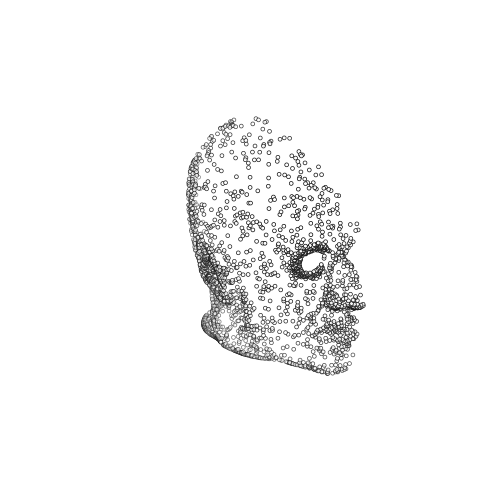

In [13]:
# point cloud - search space
ind, _ = pspd.get_points()
N = points[ind].shape[0]
num = 0.1 * N
mask = np.arange(0, N, int(N/num))

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points[ind][mask].T,
           fc='w', ec='k', s=7.5, lw=0.5)
ax.set_box_aspect(np.ptp(points[ind], axis=0))
ax.set_axis_off()
ax.view_init(30, 55)
plt.show()

In [24]:
spd, area

(5.0686895905694085, 3.6205912251607546)

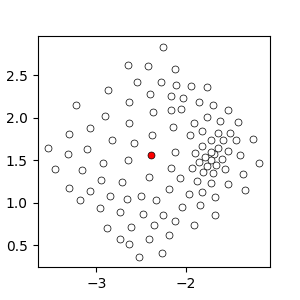

In [67]:
plt.close()
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.scatter(*nbh[(nbh != p).all(axis=1), 1:].T,
           fc='w', ec='k', s=25, lw=0.5)
ax.scatter(*p[1:],
           fc='r', ec='k', s=25, lw=0.5)
plt.show()

In [47]:
idx_at_ymin = np.argmin(nbh[:, 1])
ymin = nbh[idx_at_ymin, 1]
z_at_ymin = nbh[idx_at_ymin, 2]

idx_at_zmin = np.argmin(nbh[:, 2])
zmin = nbh[idx_at_zmin, 2]
y_at_zmin = nbh[idx_at_zmin, 1]

d = z_at_ymin - zmin
r = np.sqrt(np.ptp(nbh[:, 1]))
angle_rad = 2 * np.arcsin(d / (2 * r))
angle = np.rad2deg(angle_rad)
angle

49.23608879396203

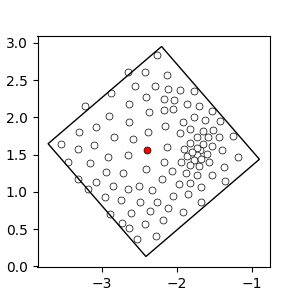

In [65]:
plt.close()
square = Rectangle(xy=(ymin + 0.05 * ymin, z_at_ymin),
                   width=a,
                   height=a,
                   angle=-angle,
                   ec='k', fc='none')
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
ax.scatter(*nbh[(nbh != p).all(axis=1), 1:].T,
           fc='w', ec='k', s=25, lw=0.5)
ax.scatter(*p[1:],
           fc='r', ec='k', s=25, lw=0.5)
ax.add_patch(square)
plt.show()

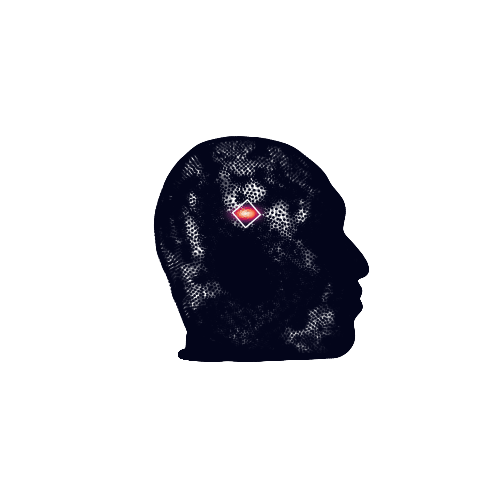

In [69]:
ind, _ = pspd.get_points()

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points.T, c=power_density, cmap=cmap, s=1)
square = Rectangle(xy=(ymin + 0.05 * ymin, z_at_ymin),
                   width=a,
                   height=a,
                   angle=-angle,
                   ec='w', fc='none')
ax.add_patch(square)
pathpatch_2d_to_3d(square, z=nbh[:, 0].min(), zdir='x')
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.set_axis_off()
ax.view_init(0, 0)
plt.show()

In [117]:
mesh.vertex_colors = o3d.utility.Vector3dVector(
    cmap(gen_power_density(query_point, vert, 2.5, 10))[:, :-1]
)
colors = np.asarray(mesh.vertex_colors)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

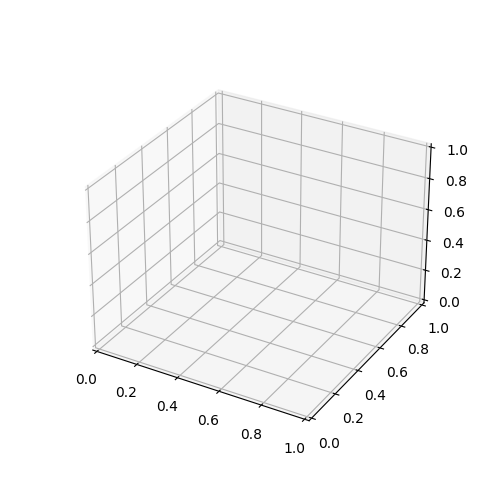

In [157]:
# surface
plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.plot_trisurf(*vert.T, triangles=tri, lightsource=ls, facecolor=colors[tri, :].mean(axis=1),)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()